In [1]:
import azureml.core
print("SDK Version:", azureml.core.VERSION)

SDK Version: 1.26.0


# 1) `ESML - TRAIN Classification, TITANIC model, and DEPLOY with predict_proba scoring

######  NB! This,InteractiveLoginAuthentication, is only needed to run 1st time, then when ws_config is written, use later CELL in notebook, that just reads that file
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
#sys.path.append(os.path.abspath("../azure-enterprise-scale-ml/esml/common/"))  # NOQA: E402
from esml import ESMLDataset, ESMLProject

p = ESMLProject()
#p.dev_test_prod="dev"
auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)
######  NB!

In [2]:
unregister_all_datasets=False

In [3]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
import pandas as pd 
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.inference_mode = False # We want "TRAIN" mode
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace

if(unregister_all_datasets):
    p.unregister_all_datasets(ws) # For DEMO purpose
    

In [4]:
p.describe()

Inference version: 1

 - ds01_titanic
projects/project002/01_titanic_model_clas/train/ds01_titanic/in/dev/2021/01/01/
projects/project002/01_titanic_model_clas/train/ds01_titanic/out/bronze/dev/
projects/project002/01_titanic_model_clas/train/ds01_titanic/out/silver/dev/
projects/project002/01_titanic_model_clas/inference/1/ds01_titanic/in/dev/2021/01/01/
 

Training GOLD
projects/project002/01_titanic_model_clas/train/gold/dev/
 

A)INFERENCE ONLINE: GOLD to score (example if realtime - today)
projects/project002/01_titanic_model_clas/inference/1/gold/dev/2021_06_16/f541b39495df41cb8eb6ba40c1e6bc50/
 

A)INFERENCE ONLINE: GOLD scored (example if realtime today)
projects/project002/01_titanic_model_clas/inference/1/scored/dev/2021_06_16/f541b39495df41cb8eb6ba40c1e6bc50/
 

B)INFERENCE BATCH: GOLD to score (example batch, datetime from config)
projects/project002/01_titanic_model_clas/inference/1/gold/dev/2021_01_01/962bce3b0a274448a2132bba959c6175/
 

B)INFERENCE BATCH: GOLD scored (ex

In [5]:
datastore = p.init() # 3) Automapping from datalake to Azure ML datasets

...
Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = FALSE. [active_in_folder.json,active_scoring_in_folder.json] not found. 
 - Using [active_in_folder.json,active_scoring_in_folder.json] from ArgParse or GIT. No override from datalake settings
ScriptExecutionException was caused by StreamAccessException.
  StreamAccessException was caused by NotFoundException.
    'AdlsGen2-ListFiles (req=1, existingItems=0)' for 'https://msftweudevcmnai2.dfs.core.windows.net/lake3?directory=projects/project002/01_titanic_model_clas/train/active&recursive=true&resource=filesystem' on storage failed with status code 'NotFound' (The specified path does not exist.), client request ID '42482b1b-9d64-4696-958b-787d05858d0f', request ID 'a314de62-a01f-005c-613a-623588000000'. Error message: {"error":{"code":"PathNotFound","message":"The specified path does not exist.\nRequestId:a314de62-a01f-005c-613a-623588000000\nTime:2021-06-15T23:01:41.4523446Z"}}
| s

In [6]:
# Feture engineering: Bronze 2 Gold - working with Azure ML Datasets with Bronze, Silver, Gold concept
esml_dataset = p.DatasetByName("ds01_titanic") # Get dataset
df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
p.save_silver(esml_dataset,df_bronze) #Bronze -> Silver

df_silver = esml_dataset.Silver.to_pandas_dataframe() 
gold_train = p.save_gold(df_silver)  #Silver -> Gold

## SUMMARY - step 1
- ESML has now `Automap` and `Autoregister` Azure ML Datasets as: `IN, SILVER, BRONZE, GOLD`
- ESML has read configuration for correct environment (DEV, TEST, PROD). 
    - Both small customers, and large Enterprise customers often wants:  DEV, TEST, PROD in `diffferent Azure ML workspaces` (and different subscriptions)
- User has done feature engineering, and saved GOLD `p.save_gold`

In [7]:
gold_train.to_pandas_dataframe().head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


# 2) `ESML` Train model in `5 codelines`

In [8]:
from esml import ESMLDataset, ESMLProject
from baselayer_azure_ml import AutoMLFactory,azure_metric_regression,azure_metric_classification
from azureml.train.automl import AutoMLConfig

automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
aml_compute = p.get_training_aml_compute(ws) # 2)Get compute, for active environment

label = "Survived"
train_6, validate_set_2, test_set_2 = p.split_gold_3(0.6,label) # 3) Auto-registerin AZURE (M03_GOLD_TRAIN | M03_GOLD_VALIDATE | M03_GOLD_TEST)          # Alt: p.Gold.random_split(percentage=0.8, seed=23)

automl_config = AutoMLConfig(task = 'classification', # 4) Override the ENV config, for model(that inhertits from enterprise DEV_TEST_PROD config baseline)
                            primary_metric = azure_metric_classification.AUC, # # Note: Regression(MAPE) are not possible in AutoML
                            compute_target = aml_compute,
                            training_data = p.GoldTrain, # is 'train_6' pandas dataframe, but as an Azure ML Dataset
                            experiment_exit_score = '0.922', # DEMO purpose (0.308 for diabetes regression, 0.6 for classification titanic)
                            label_column_name = label,
                            **automl_performance_config
                        )
via_pipeline = False # Consistent/same return values from both AutoML ALTERNATIVES (run or pipeline)
best_run, fitted_model, experiment = AutoMLFactory(p).train_pipeline(automl_config) if via_pipeline else AutoMLFactory(p).train_as_run(automl_config)

Loading AutoML config settings from: dev
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Using a model specific cluster, per configuration in project specific settings, (the integer of 'model_number' is the base for the name)
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Creating new cluster - prj02-m01-dev
Creating.........
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
image_build_compute = prj02-m01-dev
Experiment name: 01_titanic_model_clas
Azure ML Studio Workspace: msft-weu-DEV-eap-proj02_ai-amls
Start training run...
Submitting remote run.
No run_configuration provided, running on prj

Experiment,Id,Type,Status,Details Page,Docs Page
01_titanic_model_clas,AutoML_934d6699-ea12-4ded-996e-ba4bd29a2e5b,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

******************************************************************

- ESML has now fetched `configuration & train compute` for enterprise `environment (DEV,TEST or PROD)`
- ESML has `autogenerated` a AutoML-experiment, optinally as `pipline`, in correct environment.
- User has overridden some AutoML settings (`label, split percentage`, `target metric`), and use the `1-liner TRAIN` code snippet 

In [9]:
p.dev_test_prod

'dev'

# TEST SET SCORING

# Test-set: Ensure we have a TEST_SET splitted

Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.30.0, current version:1.26.0
Replacing tag run_i

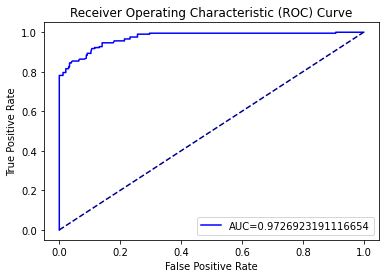

In [6]:
from baselayer_azure_ml import ESMLPipelineFactory
label = "Survived"

#rmse, r2, mean_abs_percent_error,accuracy,plt = ESMLPipelineFactory(p).get_test_scoring_4_regression(label)
auc,accuracy,f1, precision,recall,matrix, plt = ESMLPipelineFactory(p).get_test_scoring_7_classification(label)

print("AUC:")
print(auc)
print()
print("Accuracy:")
print(accuracy)
print()
print("F1 Score:")
print(f1)
print()
print("Precision:")
print(precision)
print()
print("Recall:")
print(recall)
print()
print("Confusion Matrix:")
print(matrix)


## 2b) ESML Scoring compare `1-codeline`: Promote model or not? If better, then `Register model`
- `IF` newly trained model in `current` environment (`DEV`, `TEST` or `PROD`) scores BETTER than existing model in `target` environment, then `new model` can be registered and promoted.

In [5]:
from baselayer_azure_ml import AutoMLFactory
target_env = p.dev_test_prod #"dev", test, prod  = Target environment. Does Model A score better than Model B?
print("Example: If new model scores better in DEV, we can promote this to TEST")

promote, m1_name, r1_id, m2_name, r2_run_id = AutoMLFactory(p).compare_scoring_current_vs_new_model(target_env)

print("Promote model?  {}".format(promote))
print("New Model: {} in environment {}".format(m1_name, p.dev_test_prod))
print("Existing Model: {} in environment {}".format(m2_name,target_env))

if (promote and p.dev_test_prod == target_env):# Can only register a model in same workspace (test->test) - need to retrain if going from dev->test
    AutoMLFactory(p).register_active_model(target_env)


Example: If new model scores better in DEV, we can promote this to TEST
Loading AutoML config settings from: dev
targe=source environement. Compare model version in DEV/TEST/PROD with latest registered in same DEV/TEST/PROD workspace (same workspace & subscriptiom comparison)
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, tr

# 3) ESML `Deploy model ONLINE` in `2 lines of code` (AKS) 
- Deploy "offline" MODEL from old `run` in environment To →  `DEV`, `TEST` or `PROD` environment
- ESML saves `API_key in Azure keyvault automatically`
- ESML auto-config solves 4 common 'errors/things': `correct compute name` and `valid replicas, valid agents, valid auto scaling`
    - Tip: You can adjust the number of replicas, and different CPU/memory configuration, or using a different compute target.

In [9]:
p.dev_test_prod

'dev'

In [10]:
inference_config, model, best_run = p.get_active_model_inference_config(p.ws) #  Get compute power & lib-dependecies for DOCKER...for correct (Dev,Test or Prod) environment.
service,api_uri, kv_aks_api_secret= p.deploy_automl_model_to_aks(model,inference_config,True) # Deploy: AKS dockerized with correct config (Dev,Test or Prod subscription & networking)

Loading AutoML config settings from: dev
Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.30.0, c

## 3b) ESML Test AKS webservice, `2 lines of code`

In [20]:
X_test, y_test, tags = p.get_gold_validate_Xy() # Get the X_test data, ESML knows the SPLIT and LABEL already (due to training)
print(tags)
caller_id = "10965d9c-40ca-4e47-9723-5a608a32a0e4"

df = p.call_webservice(p.ws, X_test,caller_id) # Auto-fetch key from keyvault, and calls the webservice
df.head()

M01_GOLD_VALIDATE : (532, 8)
X_test  (532, 7)
y_test  (532,)
{'split_percentage': '0.2', 'label': 'Survived'}
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Note: Fetching keys automatically via workspace keyvault.
Saving scoring to lake for project folder project002 and inference_model_version: 2 ...
...

Saved DATA to score successfully in LAKE, as file 'to_score_10965d9c-40ca-4e47-9723-5a608a32a0e4.parquet'
..
Saved SCORED data in LAKE, as file 'scored_10965d9c-40ca-4e47-9723-5a608a32a0e4.parquet'


,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result
0,3,Mr. Fridtjof Arne Madsen,male,24.00,0,0,7.14,0
1,3,Mr. Owen Harris Braund,male,22.00,1,0,7.25,0
2,3,Mr. Carl/Charles Peter Widegren,male,51.00,0,0,7.75,0
3,2,Mr. Jacob Christian Milling,male,48.00,0,0,13.00,0
4,3,Mr. Leonard Charles Moore,male,19.00,0,0,8.05,0


# Custom scoring file - predict proba

In [8]:
inference_config_to_override_and_inject, model, best_run = p.get_active_model_inference_config(p.ws) # 1) You can override this scoring_script - get a baseline, then modify...
my_custom_script_instead = 'scoring_file_dev_M01_titanic.py'
inference_config_to_override_and_inject.entry_script = 'c:\\Users\\jostrm\\OneDrive - Microsoft\\0_GIT\\2_My\\github\\azure-enterprise-scale-ml\\settings\\project_specific\\model\\dev_test_prod\\train\\automl\\' + my_custom_script_instead

inference_config_to_override_and_inject.entry_script # Verify path

Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Loading AutoML config settings from: dev
Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, training ve

'c:\\Users\\jostrm\\OneDrive - Microsoft\\0_GIT\\2_My\\github\\azure-enterprise-scale-ml\\settings\\project_specific\\model\\dev_test_prod\\train\\automl\\scoring_file_dev_M01_titanic.py'

In [9]:
# DEPLOY with custom InferenceConfig (custom scoring script)
service,api_uri, kv_aks_api_secret= p.deploy_automl_model_to_aks(model,inference_config_to_override_and_inject, True) #2) (model,inference_config, overwrite_endpoint=True,deployment_config=None):

Deploying model: AutoML934d6699e0 with verison: 2 to environment: dev with overwrite_endpoint=True
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
image_build_compute = prj02-m01-dev
Found existing AksWebservice endpoint, deleting it, since overwrite=True
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster, esml-dev-prj02, using it.
Note: Autoscale_enabled=False, or since aks_dev_test=True in config, autoscaling is automatically shut off, e.g. overridden in config (since not supported) for environment dev
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-0

# INFERENCE - Scenario "Caller/Client"

## 1) Get MockData - Get some TEST-DATA via ESMLProject...the GoldTest

In [4]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
import pandas as pd
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.inference_mode = False # We want "TRAIN" mode
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace

In [5]:
label = "Survived"
to_score = None
try:
    X_test = p.GoldTest.to_pandas_dataframe()
    to_score = X_test.drop([label], axis=1)
    print(to_score.head()) # gold_test_1 = Dataset.get_by_name(ws, name=p.dataset_gold_test_name_azure)
except: 
    print ("you need to have splitted GOLD dataset, GoldTest need to exist. Change next cell from MARKDOWN, to CODE, and run that. Try this again... ")
# #X_test, y_test, tags = p.get_gold_validate_Xy() # Get the X_test data, ESML knows the SPLIT and LABEL already (due to training)

   Pclass                                               Name     Sex   Age  \
0       3                           Miss. Bridget O'Driscoll  female  27.0   
1       2  Mrs. William John Robert (Dorothy Ann Wonnacot...  female  27.0   
2       2                               Master. Andre Mallet    male   1.0   
3       1                 Col. Oberst Alfons Simonius-Blumer    male  56.0   
4       1                        Miss. Jean Gertrude Hippach  female  16.0   

   Siblings/Spouses Aboard  Parents/Children Aboard     Fare  
0                        0                        0   7.7500  
1                        1                        0  21.0000  
2                        0                        2  37.0042  
3                        0                        0  35.5000  
4                        0                        1  57.9792  


## 2) Call AKS Webservice in 3 ways (A,B,C)
- A) Also let AKS save data to lake
- B) Use the ESML helper method (fetched keys from vault AND joins result + features)
- C) Simulate "Rest only" - No ESML dependency 
    - No ESML meaning: Fetch keys by your own from vault + join/format JSON yourself + save data yourself to lake)

### Alt 1 - ESML.call_webservice, `get PANDAS joined` dataframe
#### `Also saves to LAKE, automatically`

In [8]:
p.lakestore = p.set_lake_as_datastore(p.ws) # For Savign. This i NOT needed, if p.init() is done...which usually is the case
p.call_webservice(p.ws, to_score,"caller_id").head() # (X_test, firstRowOnly=True,pandas_result=True, api_uri=None,api_key="auto from keyvault")

Using GEN2 as Datastore
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Note: Fetching keys automatically via workspace keyvault.
Saving scoring to lake for project folder project002 and inference_model_version: 2 ...
...

Saved DATA to score successfully in LAKE, as file 'to_score_caller_id.parquet'
Saved SCORED data in LAKE, as file 'scored_caller_id.parquet'


,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result,probability
0,3,Miss. Bridget O'Driscoll,female,27.0,0,0,7.7500,1,0.922252
1,2,Mrs. William John Robert (Dorothy Ann Wonnacot...,female,27.0,1,0,21.0000,0,0.234340
2,2,Master. Andre Mallet,male,1.0,0,2,37.0042,1,0.984918
3,1,Col. Oberst Alfons Simonius-Blumer,male,56.0,0,0,35.5000,0,0.338251
4,1,Miss. Jean Gertrude Hippach,female,16.0,0,1,57.9792,1,0.999310


### Alt 2 - use compute factory, control to `get JSON back` instead of PANDAS. 
#### `No saving to LAKE`

In [9]:
result, model_version_used = p.compute_factory.call_webservice(to_score,False,False) # (X_test, firstRowOnly=True,pandas_result=True, api_uri=None,api_key="auto from keyvault")
df_res = pd.read_json(result)
to_score.join(df_res) # Need to join the FEATURES yourself, post webservice call (simulate no ESML dependancy in caller)

Note: Fetching keys automatically via workspace keyvault.


,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result,probability
0,3,Miss. Bridget O'Driscoll,female,27.00,0,0,7.7500,1,0.922252
1,2,Mrs. William John Robert (Dorothy Ann Wonnacot...,female,27.00,1,0,21.0000,0,0.234340
2,2,Master. Andre Mallet,male,1.00,0,2,37.0042,1,0.984918
3,1,Col. Oberst Alfons Simonius-Blumer,male,56.00,0,0,35.5000,0,0.338251
4,1,Miss. Jean Gertrude Hippach,female,16.00,0,1,57.9792,1,0.999310
...,...,...,...,...,...,...,...,...,...
528,2,Master. Viljo Hamalainen,male,0.67,1,1,14.5000,1,0.996252
529,1,Mr. Henry Blank,male,40.00,0,0,31.0000,0,0.377782
530,3,Mr. Sleiman Attalah,male,30.00,0,0,7.2250,0,0.013294
531,3,Miss. Ida Lefebre,female,3.00,3,1,25.4667,0,0.032332


### Alt 3 - Simualte "scoring endpoint" JSON result (No ESML dependancy `get JSON back`)
#### `No saving to LAKE` and `no JOIN` 

In [10]:
from baselayer_azure_ml import ComputeFactory
import json
keyvault = p.ws.get_default_keyvault()
api_uri = keyvault.get_secret(name='esml-dev-p02-m01-api') # titanic = m01
api_key = keyvault.get_secret(name='esml-dev-p02-m01-apisecret') #

result_json = ComputeFactory.call_webservice_static(to_score, api_uri,api_key,firstRowOnly=False) # Simulate "REST call" (no ESML dependancy)
res_dict = json.loads(result_json.text) # json -> dictionary
df_res = pd.read_json(res_dict) # dictionary -> pandas
all_result = X_test.join(df_res) # features + result
all_result

Relying on you having the keys...


,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result,probability
0,1,3,Miss. Bridget O'Driscoll,female,27.00,0,0,7.7500,1,0.922252
1,0,2,Mrs. William John Robert (Dorothy Ann Wonnacot...,female,27.00,1,0,21.0000,0,0.234340
2,1,2,Master. Andre Mallet,male,1.00,0,2,37.0042,1,0.984918
3,1,1,Col. Oberst Alfons Simonius-Blumer,male,56.00,0,0,35.5000,0,0.338251
4,1,1,Miss. Jean Gertrude Hippach,female,16.00,0,1,57.9792,1,0.999310
...,...,...,...,...,...,...,...,...,...,...
528,1,2,Master. Viljo Hamalainen,male,0.67,1,1,14.5000,1,0.996252
529,1,1,Mr. Henry Blank,male,40.00,0,0,31.0000,0,0.377782
530,0,3,Mr. Sleiman Attalah,male,30.00,0,0,7.2250,0,0.013294
531,0,3,Miss. Ida Lefebre,female,3.00,3,1,25.4667,0,0.032332


# END